# Predicting credit card fraud with an Imbalance data

1. Problem Definition

Anonymized credit card transactions labeled as fraudulent or genuine.

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.


2. Data

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


3. Evaluation

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.


4. Features

Some features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset, Time and Amount the only features which have not been transformed with PCA.


Our Goals:

   * Understand the little distribution of the "little" data that was provided to us.
   * Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm)
   * Determine the Classifiers we are going to use and decide which one has a higher accuracy.
   * Create a Neural Network and compare the accuracy to our best classifier.
   * Understand common mistaked made with imbalanced datasets.
   
   
### Key points to consider :

* Never test on the oversampled or undersampled dataset.
* If we want to implement cross validation, remember to oversample or undersample your training data     during cross-validation, not before!
* Don't use accuracy score as a metric with imbalanced datasets (will be usually high and misleading),   instead use f1-score, precision/recall score or confusion matrix

In [1]:
# import the necessary libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time


# classifier libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# other libraries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, classification_report, accuracy_score
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

### Load the dataset


In [2]:
df = pd.read_csv("creditcard.csv/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# check if there is null
df.isna().sum().max()

0

### Checking the target classes


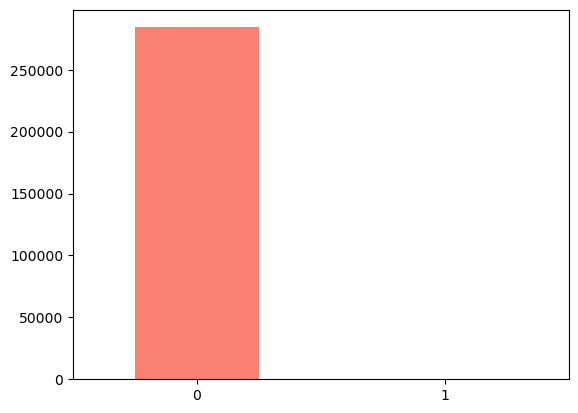

In [4]:
df.Class.value_counts().plot(kind= 'bar', color = ['salmon', 'lightblue'])
plt.xticks(rotation = 0);

**Note:** *Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!*


There are several ways to approach this classification problem taking into consideration this unbalance.
* Collect more data? Nice strategy but not applicable in this case
* Changing the performance metric:
     * Use the confusio nmatrix to calculate Precision, Recall
    * F1score (weighted average of precision recall)
    * Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
    * ROC curves - calculates sensitivity/specificity ratio.
* Resampling the dataset
    * Essentially this is a method that will process the data to have an approximate 50-50 ratio.
    * One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
    * Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

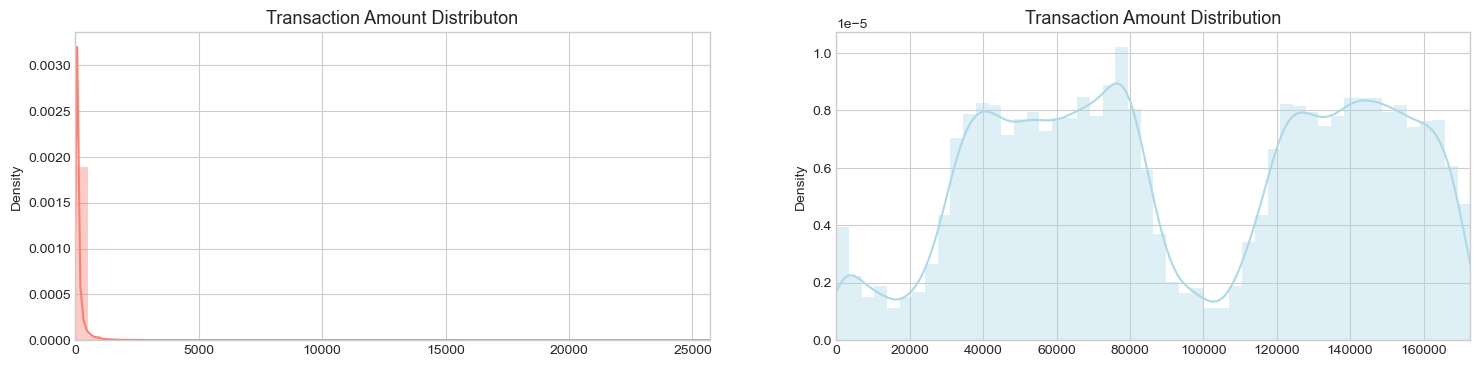

In [5]:
plt.style.use('seaborn-v0_8-whitegrid') # set the grid

fig, ax = plt.subplots(1, 2, figsize= (18, 4))

amount_val = df.Amount.values
time_val = df.Time.values

sns.distplot(amount_val, ax=ax[0],  color= 'salmon')
ax[0].set_title('Transaction Amount Distributon', fontsize = 13)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color = 'lightblue')
ax[1].set_title('Transaction Amount Distribution', fontsize = 13)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show();

We will first scale the columns comprise of `Time` and `Amount` . Time and amount should be scaled as the columns was scaed (PCA). We'll need to also create a resample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

**Resampling**, there are several ways to resample skewed data. Apart from under and over sampling, there is a very popular approach called SMOTE (Synthetic Minority Over-Sampling Technique), which is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm. In this notebook, we will use traditional UNDER-sampling.

Our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

**Why do we resample?**
We saw how dataset is heavily imbalanced. using the original dataset will cause the followin:

* Overfitting: Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs.
* Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.

In [6]:
# since other columns has been scaled we should scale the time and amount
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df.Amount.values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df.Time.values.reshape(-1, 1))

df.drop(['Time', 'Amount'], axis = 1, inplace = True)

In [7]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# change the position in the dataset
df.drop(['scaled_amount', 'scaled_time'], axis = 1, inplace = True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# the two columns are scaled
df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [8]:
# splitting the whole dataset into X and y

X = df.drop('Class', axis = 1)
y = df.Class


In [9]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes

# Lets shuffle the data before creating the subsample

df = df.sample(frac=1)

# amount of the fraud is 492 rows

fraud_df = df.loc[df.Class == 1]
non_fraud_df = df.loc[df.Class == 0][:492]

undersampled_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows

undersampled_new_df = undersampled_df.sample(frac=1, random_state=42)


undersampled_new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
225144,-0.167819,0.698222,-0.029476,0.154581,0.908356,-0.816014,1.002243,2.054640,0.027153,0.444691,...,-0.230467,0.331088,1.411415,-0.003783,-0.660083,-0.617376,-0.227932,-0.142523,-0.221112,0
150667,0.782505,0.107708,-10.850282,6.727466,-16.760583,8.425832,-10.252697,-4.192171,-14.077086,7.168288,...,-0.646818,2.541637,0.135535,-1.023967,0.406265,0.106593,-0.026232,-1.464630,-0.411682,1
39211,0.194229,-0.528061,1.166119,0.165543,-0.679168,1.340513,2.127515,3.863970,-0.597642,0.943512,...,0.045952,-0.129759,-0.645940,0.009064,0.969117,0.447679,-0.118024,0.000818,0.029296,0
189587,0.641375,0.514327,0.909124,1.337658,-4.484728,3.245358,-0.417809,-0.762119,-2.506349,0.694164,...,0.445573,0.586829,0.594078,-0.252120,0.325439,0.562766,-0.256278,0.652674,0.319879,1
88897,-0.292042,-0.262585,-5.267760,2.506719,-5.290925,4.886134,-3.343188,-1.100085,-5.810509,1.726343,...,-0.286043,0.764266,0.473262,0.548482,-0.156850,-0.710187,-0.366423,-1.486766,0.677664,1


In [10]:
# Split the subsample data

X_undersample = undersampled_new_df.drop('Class', axis = 1)
y_undersample = undersampled_new_df.Class


In [11]:
# whole dataset


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

print(f"Number train data : {len(X_train)}"
      f"\nNumber test data : {len(X_test)}"
      f"\nTotal Number of Transactions : {len(X_train) + len(X_test)}.")


# undersampled dataset

X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample,
                                                                                                    y_undersample,
                                                                                                    test_size= 0.3,
                                                                                                    random_state= 42)
print(f"Number under_train : {len(X_train_undersample)}"
      f"\nNumber under_test : {len(X_test_undersample)}"
      f"\nTotal Number of Transactions : {len(X_train_undersample) + len(X_test_undersample)}.")

Number train data : 199364
Number test data : 85443
Total Number of Transactions : 284807.
Number under_train : 688
Number under_test : 296
Total Number of Transactions : 984.


Distribution of the Classes in the undersample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


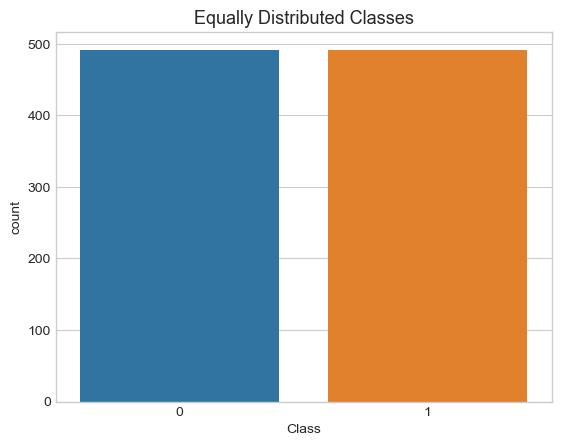

In [12]:
print('Distribution of the Classes in the undersample dataset')
print(undersampled_new_df['Class'].value_counts()/len(undersampled_new_df))



sns.countplot(x='Class', data=undersampled_new_df)
plt.title('Equally Distributed Classes', fontsize=13)
plt.show()

**Note:** *We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.*

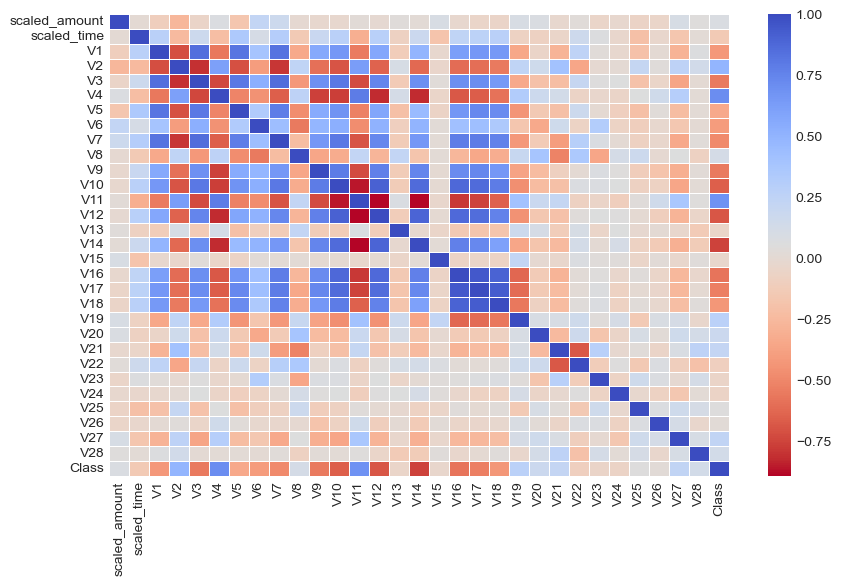

In [31]:
# lets make a correlation matrix 
corr = undersampled_new_df.corr()

fig, ax = plt.subplots( figsize= (10,6))

ax = sns.heatmap(corr, annot_kws= {"size":20}, linewidths= 0.5, fmt= '.2f', cmap= 'coolwarm_r')
ax.set_xticklabels(corr); # arranginging the x axis

**Outliers Detection:**
*Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models*

* Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.


* The Tradeoff: 
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

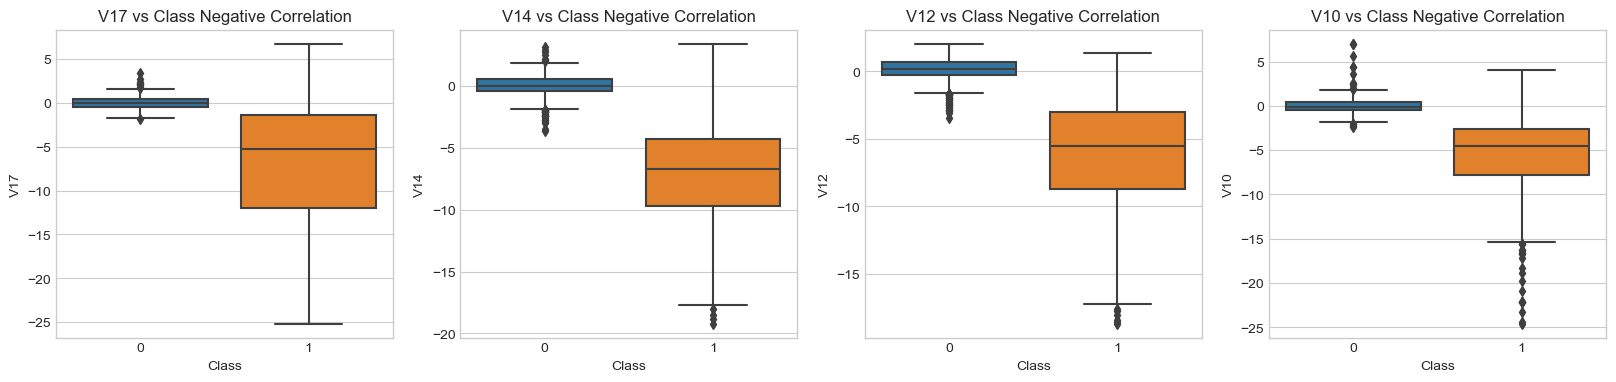

In [14]:
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class 
#(The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=undersampled_new_df, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=undersampled_new_df, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=undersampled_new_df, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=undersampled_new_df, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

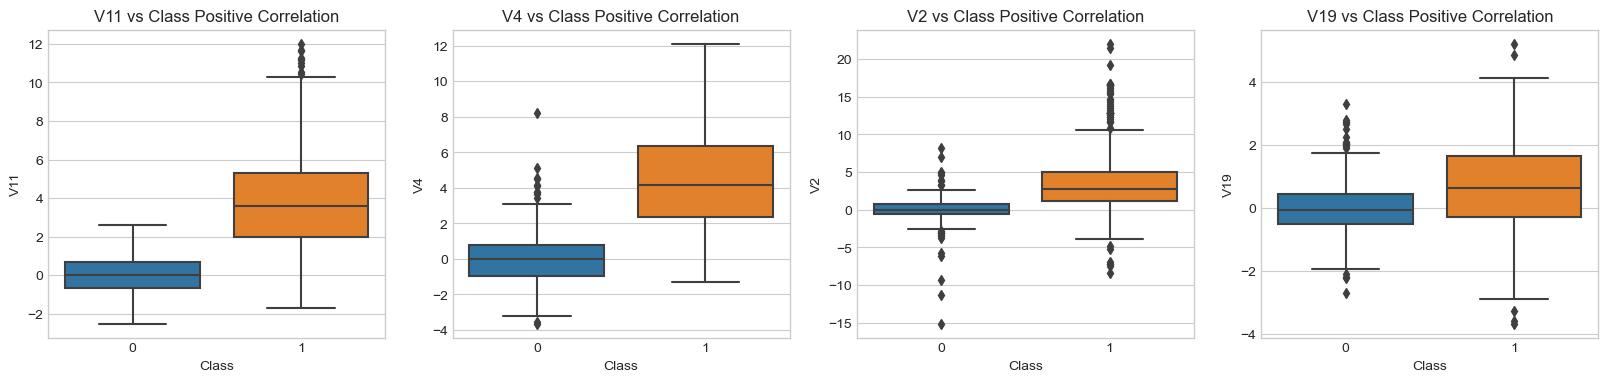

In [15]:
fig, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=undersampled_new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=undersampled_new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=undersampled_new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=undersampled_new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show();

In [16]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = undersampled_new_df['V14'].loc[undersampled_new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print(f'Quartile 25: {q25}'
      f'\nQuartile 75: {q75}')
v14_iqr = q75 - q25
print(f'iqr: {v14_iqr}')

'''
Calculate the IQR, which is the range between the 75th percentile (Q3) and the 25th percentile (Q1) 
of the data.Any data point that falls below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR can be considered
an outlier
'''
v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print(f'Cut Off: {v14_cut_off}')
print(f'V14 Lower: {v14_lower}')
print(f'V14 Upper: {v14_upper}')

outliers1 = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print(f'Feature V14 Outliers for Fraud Cases: {len(outliers1)}')
print(f'V14 outliers:{outliers1}')

undersampled_new_df = undersampled_new_df.drop(undersampled_new_df[
    (undersampled_new_df['V14'] > v14_upper) |
    (undersampled_new_df['V14'] < v14_lower)
].index)
print('----' * 10)

# -----> V12 removing outliers from fraud transactions
v12_fraud = undersampled_new_df['V12'].loc[undersampled_new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

'''
Calculate the IQR, which is the range between the 75th percentile (Q3) and the 25th percentile (Q1) 
of the data.Any data point that falls below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR can be considered
an outlier
'''
v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print(f'V12 Lower: {v12_lower}')
print(f'V12 Upper: {v12_upper}')
outliers2 = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print(f'V12 outliers: {outliers2}')
print(f'Feature V12 Outliers for Fraud Cases: {len(outliers2)}')
undersampled_new_df = undersampled_new_df.drop(undersampled_new_df[
    (undersampled_new_df['V12'] > v12_upper) | (undersampled_new_df['V12'] < v12_lower)
].index)
print(f'Number of Instances after outliers removal: {len(undersampled_new_df)}')
print('----' * 20)

# Removing outliers V10 Feature
v10_fraud = undersampled_new_df['V10'].loc[undersampled_new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

'''
Calculate the IQR, which is the range between the 75th percentile (Q3) and the 25th percentile (Q1) 
of the data.Any data point that falls below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR can be considered
an outlier
'''
v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print(f'V10 Lower: {v10_lower}')
print(f'V10 Upper: {v10_upper}')
outliers3 = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print(f'V10 outliers: {outliers3}')
print(f'Feature V10 Outliers for Fraud Cases: {len(outliers3)}')
undersampled_new_df= undersampled_new_df.drop(undersampled_new_df[
    (undersampled_new_df['V10'] > v10_upper) | (undersampled_new_df['V10'] < v10_lower)
].index)
print(f'Number of Instances after outliers removal: {len(undersampled_new_df)}')

Quartile 25: -9.692722964972386
Quartile 75: -4.282820849486865
iqr: 5.409902115485521
Cut Off: 8.114853173228282
V14 Lower: -17.807576138200666
V14 Upper: 3.8320323237414167
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.0499976898594]
----------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.5536970096458, -18.4311310279993, -18.0475965708216, -18.6837146333443]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.92033495834214
V10 outliers: [-15.2399619587112, -16.2556117491401, -23.2282548357516, -15.3460988468775, -15.1237521803455, -15.5637913387301, -15.2318333653018, -15.5637913387301, -24.4031849699728, -19.836148851696, -15.1241628144947, -16.6011969664137, -22.1870885620007, -17.1415136412892

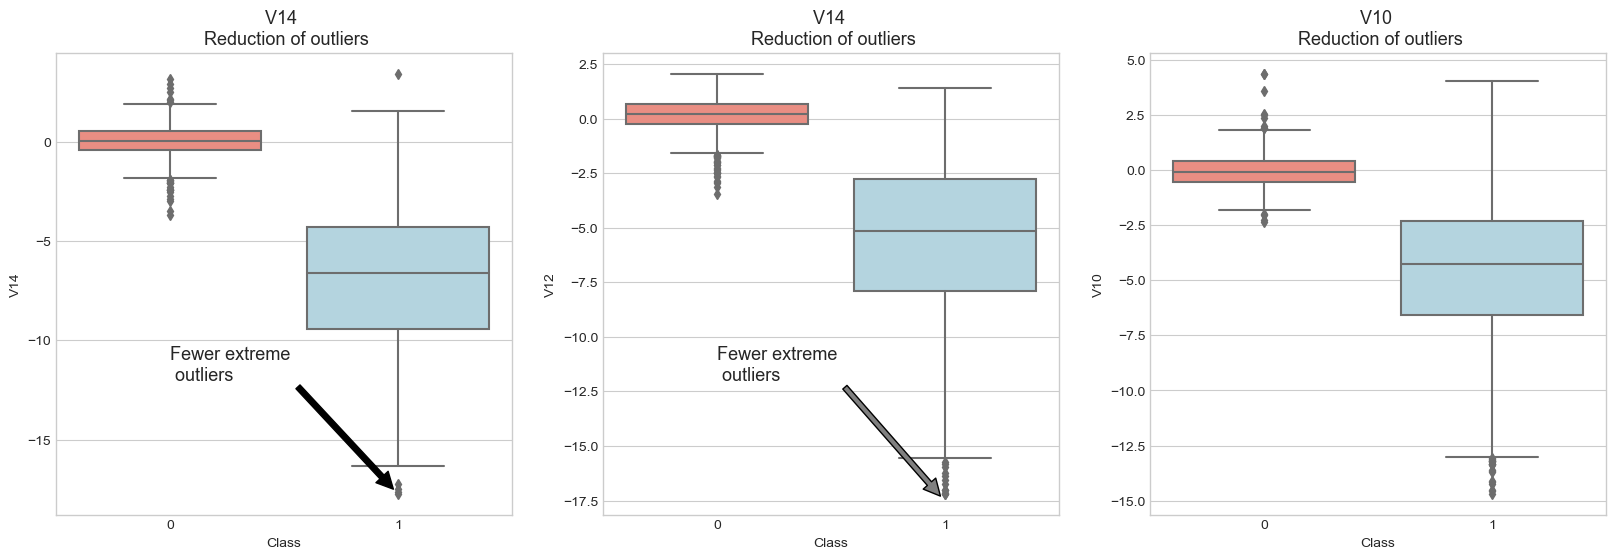

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
colors = ['salmon', 'lightblue']

# boxplots with outliers removed 
# v14
sns.boxplot(x = 'Class', y = 'V14', data = undersampled_new_df, ax=ax1, palette=colors)
ax1.set_title('V14 \n Reduction of outliers', fontsize = 13)
ax1.annotate('Fewer extreme \n outliers', xy= (0.98, -17.5), xytext=(0, -12),
             arrowprops=dict(facecolor = 'black'), fontsize = 13)

# v12
sns.boxplot(x = 'Class', y = 'V12', data = undersampled_new_df, ax= ax2, palette=colors)
ax2.set_title('V14 \n Reduction of outliers', fontsize = 13)
ax2.annotate('Fewer extreme \n outliers', xy= (0.98, -17.3), xytext=(0, -12),
             arrowprops=dict(facecolor = 'grey'), fontsize = 13)


# v14
sns.boxplot(x = 'Class', y = 'V10', data = undersampled_new_df, ax=ax3, palette=colors)
ax3.set_title('V10 \n Reduction of outliers', fontsize = 13)
ax3.annotate('Fewer extreme \n outliers', xy= (0.98, -17.5), xytext=(0, 12),
             arrowprops=dict(facecolor = 'grey'), fontsize = 13);

## Modeling

now we can train on the balanced dataset with less extreme outliers

In [18]:
# let's implement simple classifiers

classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier(),
    'Support vector Classifier': SVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier()
}

def fit_and_score(classifiers, X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample):
    '''
    fits and evaluates given machine learning models
    '''
    # randomseed
    np.random.seed(42)
    # Make the list to keep the model scores
    model_scores= {}
    for name, classifier in classifiers.items():
        classifier.fit(X_train_undersample, y_train_undersample)
        
        # Evaluate the model and append its score to model_scores
        model_scores[name] = classifier.score(X_test_undersample, y_test_undersample)
    return model_scores

In [19]:
classifier_scores = fit_and_score(classifiers=classifiers,
                                  X_train_undersample=X_train_undersample,
                                  X_test_undersample=X_test_undersample,
                                  y_train_undersample=y_train_undersample,
                                  y_test_undersample=y_test_undersample)
classifier_scores

{'LogisticRegression': 0.9425675675675675,
 'KNN': 0.9290540540540541,
 'RandomForest': 0.9391891891891891,
 'Support vector Classifier': 0.9256756756756757,
 'DecisionTreeClassifier': 0.8952702702702703}

<Axes: >

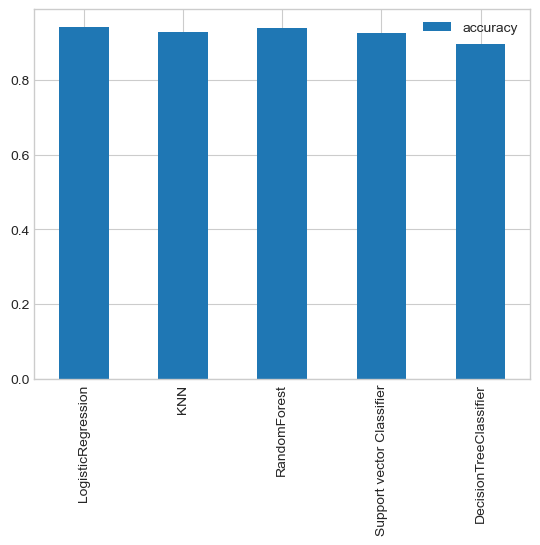

In [20]:
# let's virtualize the model accuracy
compare_df = pd.DataFrame(classifier_scores, index = ['accuracy'])
compare_df.T.plot.bar()

In [21]:
# let Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV
#logistic Regression

log_reg_grid = {'C': np.logspace(-4, 4, 20),
                
                'solver': ['liblinear']}
grid_log_reg = GridSearchCV(LogisticRegression(),
                            param_grid= log_reg_grid)
grid_log_reg.fit(X_train_undersample, y_train_undersample)
"""
we automatically get the logistic regression with the best parameters
"""
log_reg = grid_log_reg.best_estimator_

"""
KNN_grid = {'n_neighbors': list(range(1, 21)),
            'leaf_size': [20]}
grid_KNN =GridSearchCV(KNeighborsClassifier(),
                       param_grid= KNN_grid)
grid_KNN.fit(X_train_undersample, y_train_undersample)

# get the KNN best estimator
KNNeigh = grid_KNN.best_estimator_

# Support Vector Classifier
svc_grid = {'C': [0.5, 0.7, 0.9, 1], 
            'kernel': ['sigmoid']}
grid_svc = GridSearchCV(SVC(), 
                        param_grid=svc_grid)
grid_svc.fit(X_train_undersample, y_train_undersample)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_grid = {"criterion": ["entropy"],
             "max_depth": list(range(2,4,1)), 
             "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(),
                         param_grid=tree_grid)
grid_tree.fit(X_train_undersample, y_train_undersample)

# tree best estimator
tree_clf = grid_tree.best_estimator_

# Random fores classifier
rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}
grid_rf= GridSearchCV(RandomForestClassifier(),
                     param_grid= rf_grid)

grid_rf.fit(X_train_undersample, y_train_undersample)

# rf best estimator
rf_clf = grid_rf.best_estimator_
"""

'\nKNN_grid = {\'n_neighbors\': list(range(1, 21)),\n            \'leaf_size\': [20]}\ngrid_KNN =GridSearchCV(KNeighborsClassifier(),\n                       param_grid= KNN_grid)\ngrid_KNN.fit(X_train_undersample, y_train_undersample)\n\n# get the KNN best estimator\nKNNeigh = grid_KNN.best_estimator_\n\n# Support Vector Classifier\nsvc_grid = {\'C\': [0.5, 0.7, 0.9, 1], \n            \'kernel\': [\'sigmoid\']}\ngrid_svc = GridSearchCV(SVC(), \n                        param_grid=svc_grid)\ngrid_svc.fit(X_train_undersample, y_train_undersample)\n\n# SVC best estimator\nsvc = grid_svc.best_estimator_\n\n# DecisionTree Classifier\ntree_grid = {"criterion": ["entropy"],\n             "max_depth": list(range(2,4,1)), \n             "min_samples_leaf": list(range(5,7,1))}\ngrid_tree = GridSearchCV(DecisionTreeClassifier(),\n                         param_grid=tree_grid)\ngrid_tree.fit(X_train_undersample, y_train_undersample)\n\n# tree best estimator\ntree_clf = grid_tree.best_estimator_\n\

In [22]:
log_reg_score = cross_val_score(log_reg, X_train_undersample, y_train_undersample, cv=5)
print(f'Logistic Regression Cross Validation Score: {log_reg_score.mean() * 100 :.2f}%')

'''
knn_score = cross_val_score(KNNeigh, X_train, y_train, cv=5)
print(f'Knears Neighbors Cross Validation Score : {round(knn_score) * 100}.2f%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print(f'Support Vector Classifier Cross Validation Score: {round(svc_score) * 100}.2f%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print(f'DecisionTree Classifier Cross Validation Score: {round(log_reg_score) * 100}.2f%')

rf_score = cross_val_score(rf_clf, X_train_undersample, y_train_undersample, cv = 5)
print(f"RandomForest Classifier Cross Validation Score: {round(rf_score) * 100}.2f%")
'''

Logistic Regression Cross Validation Score: 94.33%


'\nknn_score = cross_val_score(KNNeigh, X_train, y_train, cv=5)\nprint(f\'Knears Neighbors Cross Validation Score : {round(knn_score) * 100}.2f%\')\n\nsvc_score = cross_val_score(svc, X_train, y_train, cv=5)\nprint(f\'Support Vector Classifier Cross Validation Score: {round(svc_score) * 100}.2f%\')\n\ntree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)\nprint(f\'DecisionTree Classifier Cross Validation Score: {round(log_reg_score) * 100}.2f%\')\n\nrf_score = cross_val_score(rf_clf, X_train_undersample, y_train_undersample, cv = 5)\nprint(f"RandomForest Classifier Cross Validation Score: {round(rf_score) * 100}.2f%")\n'

Recall metric in the testing dataset:  0.9259259259259259


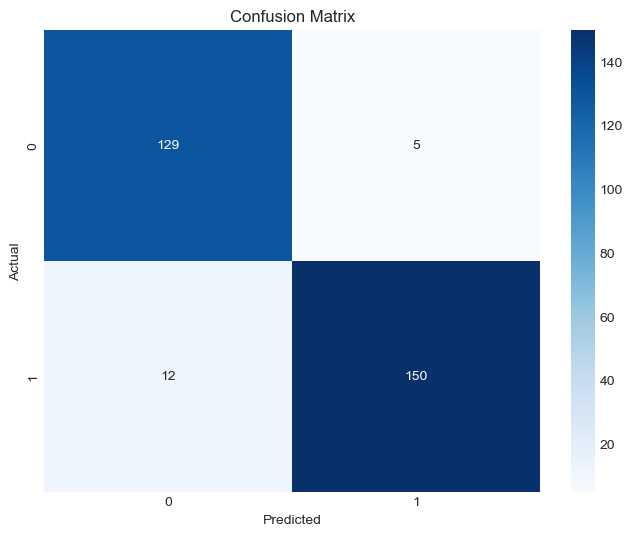

In [23]:
from sklearn.metrics import confusion_matrix


y_pred_undersample = log_reg.predict(X_test_undersample.values)

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ",
      cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

So, the model is offering an 92.5% recall accuracy on the generalised unseen data (test set). Not a bad percentage to be the first try. However, recall this is a 92.5% recall accuracy measure on the undersampled test set.
With this result, let's apply the model we fitted and test it on the whole data.

Recall metric in the testing dataset:  0.9485294117647058


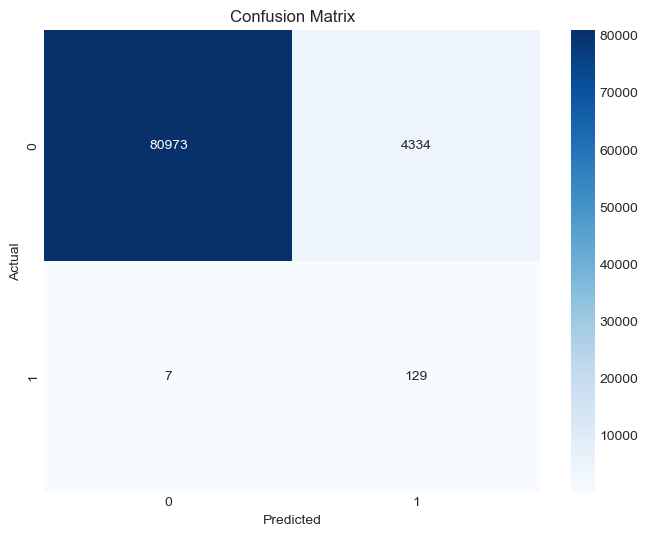

In [24]:
y_pred = log_reg.predict(X_test.values)

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ",
      cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

AUC and ROC curve are also interesting to check if the model is also predicting as a whole correctly and not making many errors.

In [25]:
auc_score = roc_auc_score(y_test_undersample,y_pred_undersample)
# Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9443


In [26]:
from sklearn.metrics import roc_curve
y_pred_undersample_score = log_reg.fit(
    X_train_undersample,
    y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

#calculate the rate fpr, tpr and threshold
fpr, tpr, threshold= roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score) 

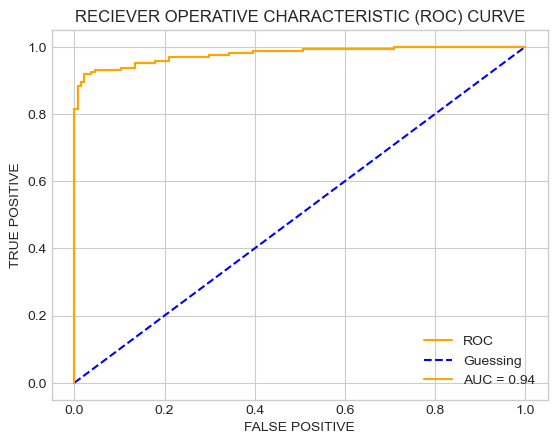

In [27]:
# For the calculation to make sense lets plot it using my function

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, color= 'orange', label= 'ROC') # model plot 
    #create a guessed plot 
    plt.plot([0,1], [0,1], linestyle= '--', color= 'b', label= 'Guessing')
    # add the auc score
    plt.plot(fpr, tpr, 'orange',label='AUC = %0.2f'% auc_score)
    # customized the plot
    plt.xlabel('FALSE POSITIVE')
    plt.ylabel('TRUE POSITIVE')
    plt.title('RECIEVER OPERATIVE CHARACTERISTIC (ROC) CURVE')
    plt.legend()
    plt.show()
plot_roc(fpr,tpr)

In [28]:
# show classification report 

print(classification_report(y_test_undersample, y_pred_undersample))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       134
           1       0.97      0.93      0.95       162

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



Recall metric in the testing dataset (Threshold >= 0.1): 0.97
Recall metric in the testing dataset (Threshold >= 0.2): 0.94
Recall metric in the testing dataset (Threshold >= 0.3): 0.93
Recall metric in the testing dataset (Threshold >= 0.4): 0.93
Recall metric in the testing dataset (Threshold >= 0.5): 0.93
Recall metric in the testing dataset (Threshold >= 0.6): 0.92
Recall metric in the testing dataset (Threshold >= 0.7): 0.90
Recall metric in the testing dataset (Threshold >= 0.8): 0.90
Recall metric in the testing dataset (Threshold >= 0.9): 0.88


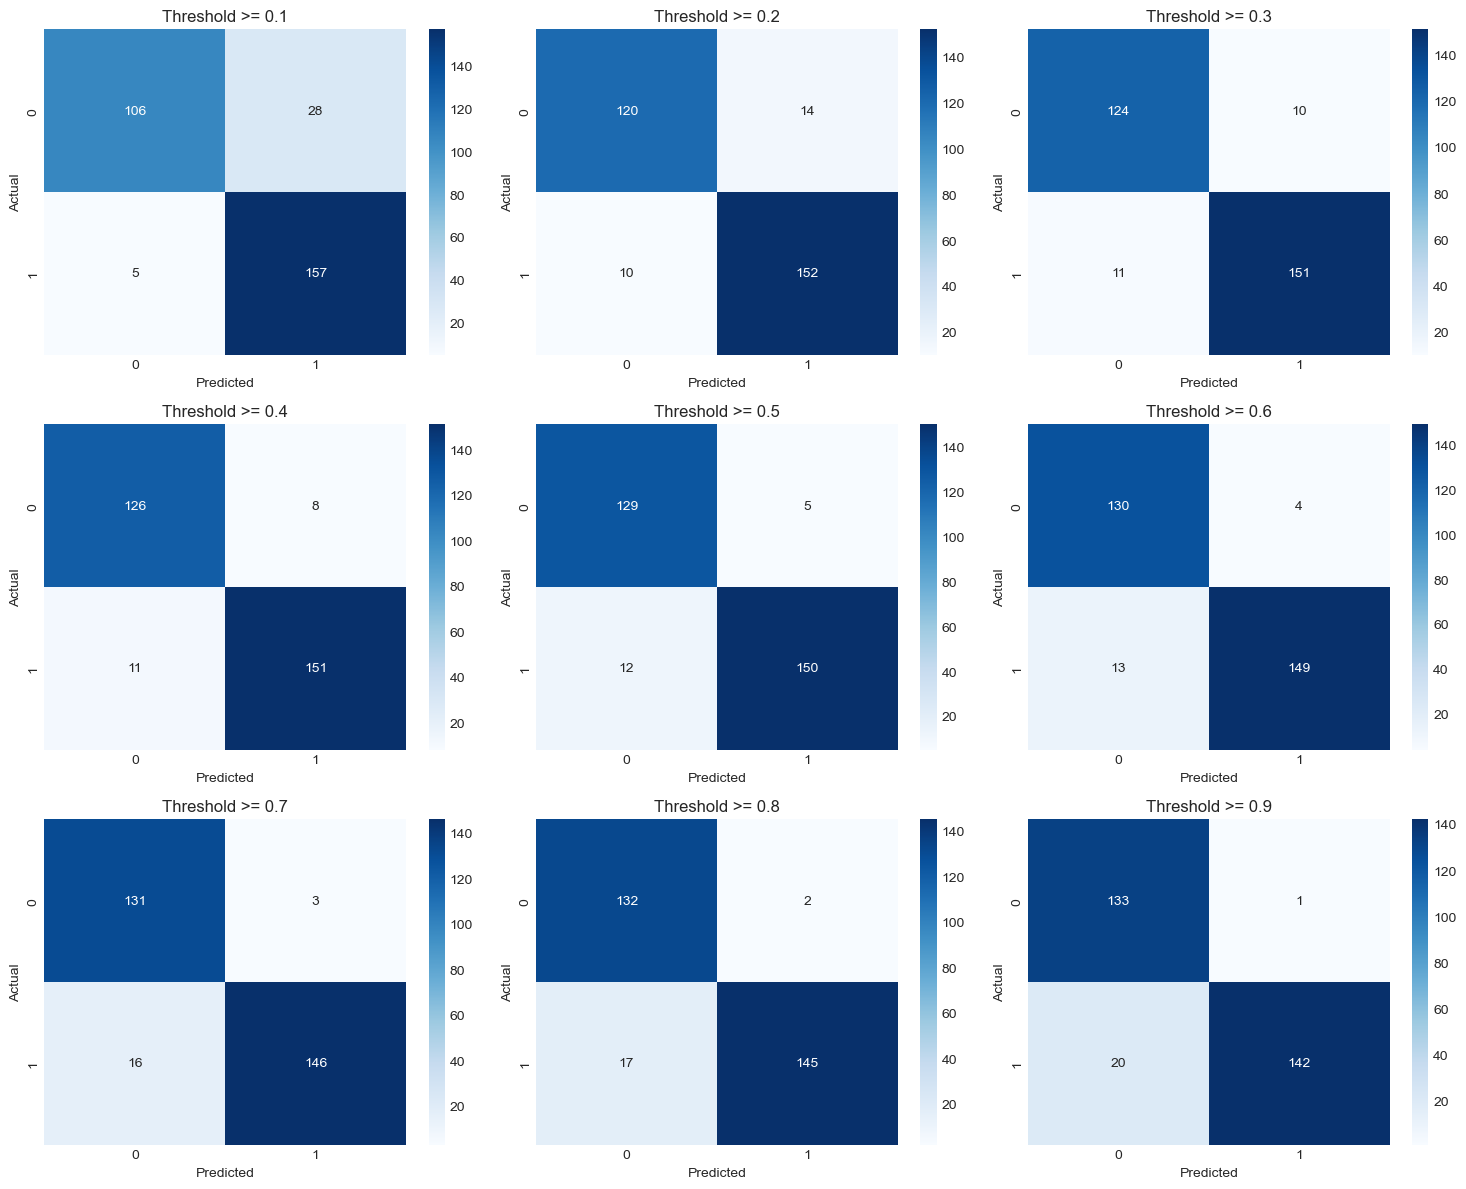

In [29]:
y_pred_undersample_proba = log_reg.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize=(15, 12))  # Adjust the figure size for better visualization

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    # Calculate and print the recall metric
    recall_metric = cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    print(f"Recall metric in the testing dataset (Threshold >= {i}): {recall_metric:.2f}")
    
    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    sns.heatmap(cnf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f'Threshold >= {i}')

plt.tight_layout()
plt.show() 


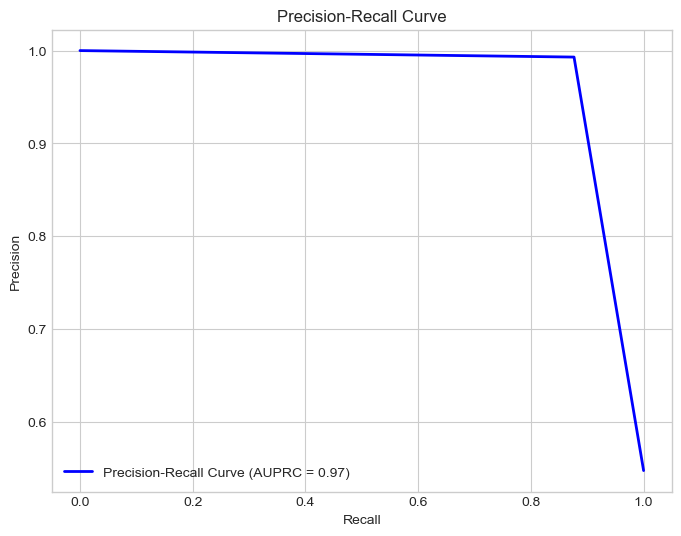

AUPRC: 0.9685588852255518


In [32]:
from sklearn.metrics import precision_recall_curve, auc
# Calculate precision and recall values at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test_undersample, y_test_predictions_high_recall)

# Calculate AUPRC using the area under the precision-recall curve
auprc = auc(recall, precision)

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall Curve (AUPRC = {auprc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)

plt.show()

print('AUPRC:', auprc)



An AUPRC (Area Under the Precision-Recall Curve) value of 0.968 is excellent in my take, especially for a binary classification model. The AUPRC measures the trade-off between precision and recall, which are important metrics in imbalanced datasets.

Here's a general interpretation of AUPRC values:

* *AUPRC close to 1: This indicates an excellent model that achieves both high precision and high recall. It means the model is very good at correctly classifying positive examples while minimizing false positives.*

* *AUPRC around 0.5: This suggests a model that performs no better than random guessing. Precision and recall are balanced, but the model isn't effectively distinguishing between positive and negative cases.*

* *AUPRC below 0.5: This indicates a poor model that performs worse than random guessing.*

In our case, with an AUPRC of 0.9685, our model is doing significantly better than random guessing.
